In [1]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from ray import tune
from ray import train
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


c:\Users\TonVo\anaconda3\envs\myenv\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
torch.manual_seed(2023)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
data = pd.read_excel('dataset_final.xlsx')
data = data.dropna(thresh=len(data.columns)-10)
data = data.fillna(method='ffill')
data.tail()

C:\Users\TonVo\AppData\Local\Temp\ipykernel_4560\2340567172.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


,DATE,NASDAQ100,NASDAQCOM,WILL5000PR,DAAA,DCOILWTICO,DGS30,DPRIME,T10Y2Y,T10Y3M,...,VOLUME,RETURN,ADL,WR,RVI,EMA,TR,UO,AAPL,MSFT
9788,2023-09-19,15191.23,13678.19,44733.86,5.10,91.16,4.43,8.5,-0.71,-1.17,...,3.614880e+09,-0.002151,2.153461e+12,-78.0646,0.6052,4463.8448,36.9199,4.2918,179.070007,328.649994
9789,2023-09-20,14969.92,13469.13,44327.34,5.07,89.20,4.40,8.5,-0.77,-1.21,...,3.308450e+09,-0.009395,2.150244e+12,-99.4135,0.3447,4455.6255,59.6499,2.5001,175.490005,320.769989
9790,2023-09-21,14694.24,13223.98,43579.31,5.21,89.56,4.56,8.5,-0.63,-1.08,...,3.662340e+09,-0.016401,2.146712e+12,-99.6086,0.2868,4438.8754,73.0303,0.6814,173.929993,319.529999
9791,2023-09-22,14701.10,13211.81,43482.13,5.15,90.00,4.53,8.5,-0.66,-1.12,...,3.349570e+09,-0.002296,2.143947e+12,-98.1952,0.2777,4423.0334,40.9097,0.1672,174.789993,317.010010
9792,2023-09-25,14768.90,13271.32,43654.44,5.29,89.68,4.67,8.5,-0.54,-1.03,...,3.195650e+09,0.004023,2.146952e+12,-83.4011,0.4286,4411.6209,35.8096,0.0924,176.080002,317.540009


In [4]:
def split_data(data, lookback):
    data_raw = data.to_numpy()
    X_list = []
    y_list = []

    for index in range(len(data_raw) - lookback): 
        X_list.append(data_raw[index: index + lookback, 1:])
        y_list.append(data_raw[index + lookback, -9])

    X = np.array(X_list)
    y = np.array(y_list)

    return X, y

lookback = 14

X, y = split_data(data, lookback)

In [5]:
train_length = int(len(X) * 0.85)
val_length = int(len(X) * 0.05)
test_length = len(X) - train_length - val_length

In [6]:
X_train = X[:train_length]
y_train = y[:train_length]

X_val = X[train_length:train_length+val_length]
y_val = y[train_length:train_length+val_length]

X_test = X[train_length+val_length:]
y_test = y[train_length+val_length:]

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_2D = X_train.reshape(-1, X_train.shape[-1])

X_train_scaled_2D = scaler.fit_transform(X_train_2D)

X_train_scaled = X_train_scaled_2D.reshape(X_train.shape)

X_val_scaled = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)

X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [8]:
X_train_t = torch.tensor(X_train_scaled).float()
y_train_t = torch.tensor(y_train).float()

X_val_t = torch.tensor(X_val_scaled).float()
y_val_t = torch.tensor(y_val).float()

X_test_t = torch.tensor(X_test_scaled).float()
y_test_t = torch.tensor(y_test).float()

In [9]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(LSTMModel, self).__init__()
        
        self.lstm_layers = nn.ModuleList()
        
        self.lstm_layers.append(nn.LSTM(input_dim, hidden_dims[0], batch_first=True))
        
        for i in range(1, len(hidden_dims)):
            self.lstm_layers.append(nn.LSTM(hidden_dims[i-1], hidden_dims[i], batch_first=True))
        
        self.fc1 = nn.Linear(hidden_dims[-1], 64)
        self.leakyrelu1 = nn.LeakyReLU()
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        for lstm in self.lstm_layers:
            x, _ = lstm(x)
        
        x = x[:, -1, :]
        
        x = self.fc1(x)
        x = self.leakyrelu1(x)
        x = self.fc2(x)
        
        return x

In [10]:
input_dim = 22
output_dim = 1

In [11]:
from torch.utils.data import TensorDataset, DataLoader

train_data = TensorDataset(X_train_t, y_train_t)
val_data = TensorDataset(X_val_t, y_val_t)

In [17]:
model = LSTMModel(22, [256, 512, 256, 128], 1).to(device)

train_data_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_data_loader = DataLoader(val_data, batch_size=16, shuffle=False)

optimizer = torch.optim.AdamW(model.parameters(), lr=2.18532e-05)

criterion = nn.MSELoss()

best_loss = float('inf')
best_model = None

for epoch in range(100):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_data_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs).squeeze()
        loss = criterion(outputs, targets)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_loss /= len(train_data_loader)

    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for inputs, targets in val_data_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            outputs = outputs.squeeze()
            loss = criterion(outputs, targets)
            val_loss += loss.item()

        val_loss /= len(val_data_loader)

    if val_loss < best_loss:
        best_loss = val_loss
        best_model = model.state_dict()

        torch.save(best_model, 'l2_loss_model.pth')
        print("Saving model...")

    print(f'Epoch {epoch+1} | Train Loss: {train_loss} | Val Loss: {val_loss:}')

Saving model...
Epoch 1 | Train Loss: 0.00029066016088427746 | Val Loss: 8.87315265572397e-05
Saving model...
Epoch 2 | Train Loss: 0.00013064762405414932 | Val Loss: 8.805491049012441e-05
Saving model...
Epoch 3 | Train Loss: 0.0001305351191573332 | Val Loss: 8.59505366255083e-05
Epoch 4 | Train Loss: 0.0001306052272429879 | Val Loss: 8.627401281652662e-05
Epoch 5 | Train Loss: 0.0001304077329523968 | Val Loss: 8.800783040593766e-05
Saving model...
Epoch 6 | Train Loss: 0.00012998740729459364 | Val Loss: 8.572118528415255e-05
Epoch 7 | Train Loss: 0.0001303855279544962 | Val Loss: 8.586417070546303e-05
Epoch 8 | Train Loss: 0.0001300789584516802 | Val Loss: 8.753963174967794e-05
Epoch 9 | Train Loss: 0.00012960477055733272 | Val Loss: 8.597638779974658e-05
Epoch 10 | Train Loss: 0.00012931702881052257 | Val Loss: 8.587983465986326e-05
Epoch 11 | Train Loss: 0.00012981969687741703 | Val Loss: 8.635259240084755e-05
Epoch 12 | Train Loss: 0.00012918069875969917 | Val Loss: 8.644827075841

In [18]:
model.load_state_dict(torch.load('l2_loss_model.pth'))

<All keys matched successfully>

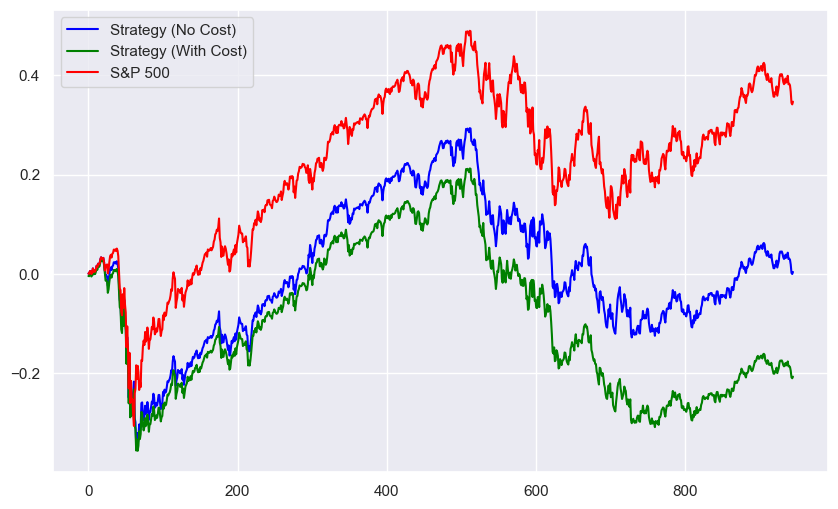

In [36]:
outputs_test = model(X_test_t.to(device))

outputs1_np = outputs_test.detach().cpu().numpy()
y_test1_t_np = y_test_t.detach().cpu().numpy()

df = pd.DataFrame({
    'PredictedReturn': outputs1_np.flatten(),
    'AssetReturn': y_test1_t_np.flatten()
})

df['Signal'] = np.sign(df['PredictedReturn'])

trading_cost = 0.005

df['StrategyReturnNoCost'] = df['Signal'] * df['AssetReturn']

df['StrategyReturnWithCost'] = df['StrategyReturnNoCost'] - trading_cost * (df['Signal'].diff() != 0)

df['CumulativeReturnNoCost'] = (1 + df['StrategyReturnNoCost']).cumprod() - 1

df['CumulativeReturnWithCost'] = (1 + df['StrategyReturnWithCost']).cumprod() - 1

df['BenchmarkCumulativeReturn'] = (1 + df['AssetReturn']).cumprod() - 1

plt.figure(figsize=(10,6))
plt.plot(df['CumulativeReturnNoCost'], label='Strategy (No Cost)', color='blue')
plt.plot(df['CumulativeReturnWithCost'], label='Strategy (With Cost)', color='green')
plt.plot(df['BenchmarkCumulativeReturn'], label='S&P 500', color='red')
plt.legend()
plt.savefig('l2_loss.svg')
plt.show()

In [37]:
def calculate_max_drawdown(cumulative_return_series):
    normalized_series = (cumulative_return_series + 1) * 100
    running_max = np.maximum.accumulate(normalized_series)
    drawdown = normalized_series - running_max
    mdd = drawdown / running_max
    return mdd.min()

strategy_mdd = calculate_max_drawdown(df['CumulativeReturnWithCost'])

benchmark_mdd = calculate_max_drawdown(df['BenchmarkCumulativeReturn'])

print(f'Maximum Strategy Drawdown: {strategy_mdd * 100:.2f}%')
print(f'Maximum Benchmark Drawdown: {benchmark_mdd * 100:.2f}%')

Maximum Strategy Drawdown: -42.91%
Maximum Benchmark Drawdown: -33.92%


In [38]:
sharpe_ratio_with_cost = np.sqrt(252) * df['StrategyReturnWithCost'].mean() / df['StrategyReturnWithCost'].std()

sharpe_ratio_benchmark = np.sqrt(252) * df['AssetReturn'].mean() / df['AssetReturn'].std()

print(f"Sharpe Ratio with Cost: {sharpe_ratio_with_cost}")
print(f"Sharpe Ratio Benchmark: {sharpe_ratio_benchmark}")

Sharpe Ratio with Cost: -0.1427769792711953
Sharpe Ratio Benchmark: 0.4555817005333269


In [34]:
# get the cumulative return
cum_ret = df['CumulativeReturnWithCost'].iloc[-1]
cum_ret_sp = df['BenchmarkCumulativeReturn'].iloc[-1]

In [35]:
cum_ret, cum_ret_sp

(-0.19692307422660094, -0.0008624196)

In [21]:
from captum.attr import IntegratedGradients

model.train()

ig = IntegratedGradients(model)

X_test_t_subset = X_test_t[:200]

median_baseline = X_test_t_subset.median(dim=0).values

median_baseline = median_baseline.unsqueeze(0).expand_as(X_test_t_subset)

attributions, delta = ig.attribute(X_test_t_subset.to(device), median_baseline.to(device), target=0, return_convergence_delta=True)

average_attributions_median = attributions.mean(dim=0).cpu().numpy()

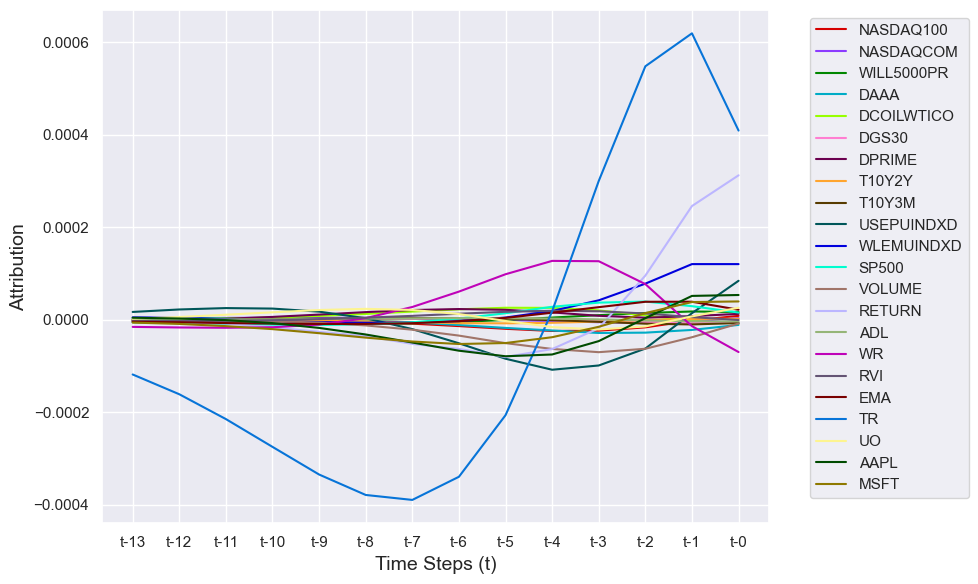

In [28]:
import colorcet as cc

fig, ax = plt.subplots(figsize=(10, 6))

sns.set()

feature_names = ['NASDAQ100', 'NASDAQCOM', 'WILL5000PR', 'DAAA', 'DCOILWTICO',
                 'DGS30', 'DPRIME', 'T10Y2Y', 'T10Y3M', 'USEPUINDXD', 'WLEMUINDXD',
                 'SP500', 'VOLUME', 'RETURN', 'ADL', 'WR', 'RVI', 'EMA', 'TR', 'UO',
                 'AAPL', 'MSFT']

# Get the colorcet palette
cmap = sns.color_palette(cc.glasbey, n_colors=len(feature_names))

for i in range(average_attributions_median.shape[1]):
    sns.lineplot(x=range(average_attributions_median.shape[0]), y=average_attributions_median[:, i], ax=ax, label=feature_names[i], color=cmap[i])

ax.set_xlabel('Time Steps (t)', fontsize=14)
ax.set_ylabel('Attribution', fontsize=14)

ax.set_xticks(range(average_attributions_median.shape[0]))
ax.set_xticklabels([f't-{average_attributions_median.shape[0] - i - 1}' for i in range(average_attributions_median.shape[0])])  # Reverse the labels

ax.grid(True)

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

plt.savefig('average_attributions_median.svg')
plt.show()

In [42]:
average_attributions_median_tensor = torch.from_numpy(average_attributions_median)

attributions_sum = torch.sum(torch.abs(average_attributions_median_tensor), dim=0)

attributions_normalized = attributions_sum / torch.sum(attributions_sum)

feature_names = ['NASDAQ100', 'NASDAQCOM', 'WILL5000PR', 'DAAA', 'DCOILWTICO',
                 'DGS30', 'DPRIME', 'T10Y2Y', 'T10Y3M', 'USEPUINDXD', 'WLEMUINDXD',
                 'SP500', 'VOLUME', 'RETURN', 'ADL', 'WR', 'RVI', 'EMA', 'TR', 'UO',
                 'AAPL', 'MSFT']

for i in range(average_attributions_median_tensor.shape[1]):
    print(f'Importance of {feature_names[i]}: {attributions_normalized[i]}')

Importance of NASDAQ100: 0.01325336963073142
Importance of NASDAQCOM: 0.004834550327226116
Importance of WILL5000PR: 0.01233483491793201
Importance of DAAA: 0.016178083844324898
Importance of DCOILWTICO: 0.016158377748049693
Importance of DGS30: 0.003636238453767592
Importance of DPRIME: 0.01533937192450256
Importance of T10Y2Y: 0.004313692930831683
Importance of T10Y3M: 0.004716101460408643
Importance of USEPUINDXD: 0.06313065071263457
Importance of WLEMUINDXD: 0.041671028256222487
Importance of SP500: 0.022263151114892334
Importance of VOLUME: 0.03730252187486014
Importance of RETURN: 0.10254171015629791
Importance of ADL: 0.0027368066411327823
Importance of WR: 0.06800865239960116
Importance of RVI: 0.011009600021020522
Importance of EMA: 0.01996998668388537
Importance of TR: 0.43054459033320924
Importance of UO: 0.0200273912856429
Importance of AAPL: 0.048878004662906864
Importance of MSFT: 0.041151284619919244


C:\Users\TonVo\AppData\Local\Temp\ipykernel_4560\806789169.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importance_df, palette='viridis_r', linewidth=0.3)


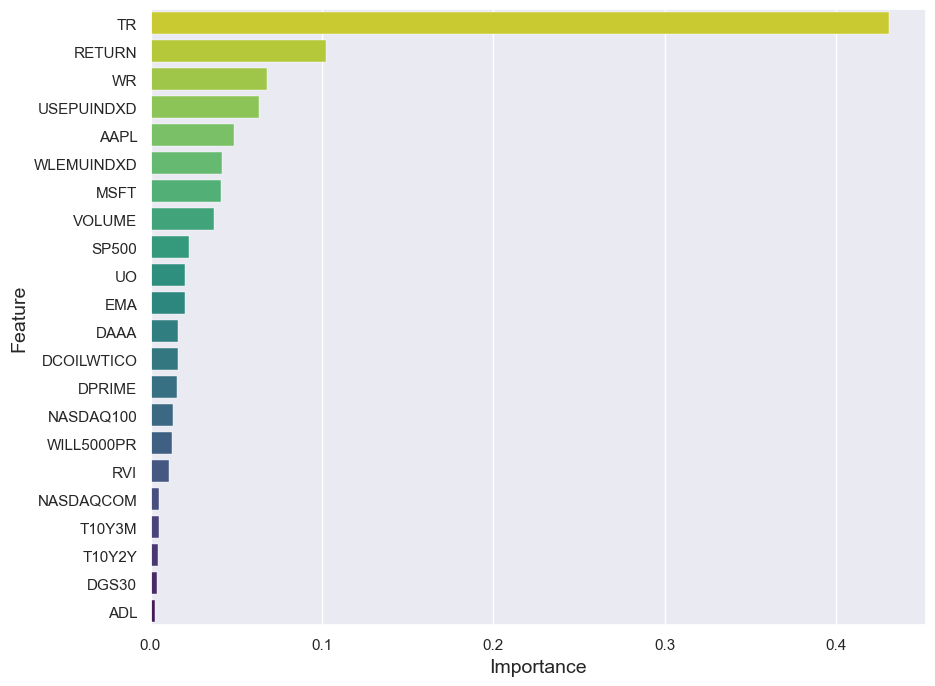

In [43]:
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': attributions_normalized
})

importance_df = importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x='importance', y='feature', data=importance_df, palette='viridis_r', linewidth=0.3)

plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)

plt.savefig('feature_importance_mse.svg')

plt.show()

C:\Users\TonVo\AppData\Local\Temp\ipykernel_4560\3015077053.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f't-{average_attributions_tensor.shape[0] - i - 1}' for i in range(average_attributions_tensor.shape[0])], y=attributions_normalized_np, palette='viridis')


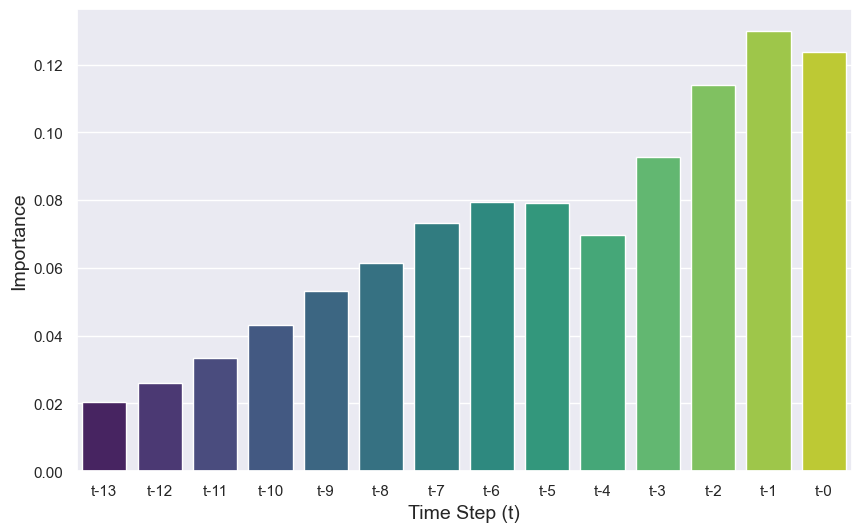

In [44]:
average_attributions_tensor = torch.from_numpy(average_attributions_median)

attributions_sum = torch.sum(torch.abs(average_attributions_tensor), dim=1)

attributions_normalized = attributions_sum / torch.sum(attributions_sum)

attributions_normalized_np = attributions_normalized.cpu().numpy()

plt.figure(figsize=(10, 6))
sns.barplot(x=[f't-{average_attributions_tensor.shape[0] - i - 1}' for i in range(average_attributions_tensor.shape[0])], y=attributions_normalized_np, palette='viridis')

plt.xlabel('Time Step (t)', fontsize=14)
plt.ylabel('Importance', fontsize=14)

plt.savefig('time_step_importance_mse.svg')
plt.show()

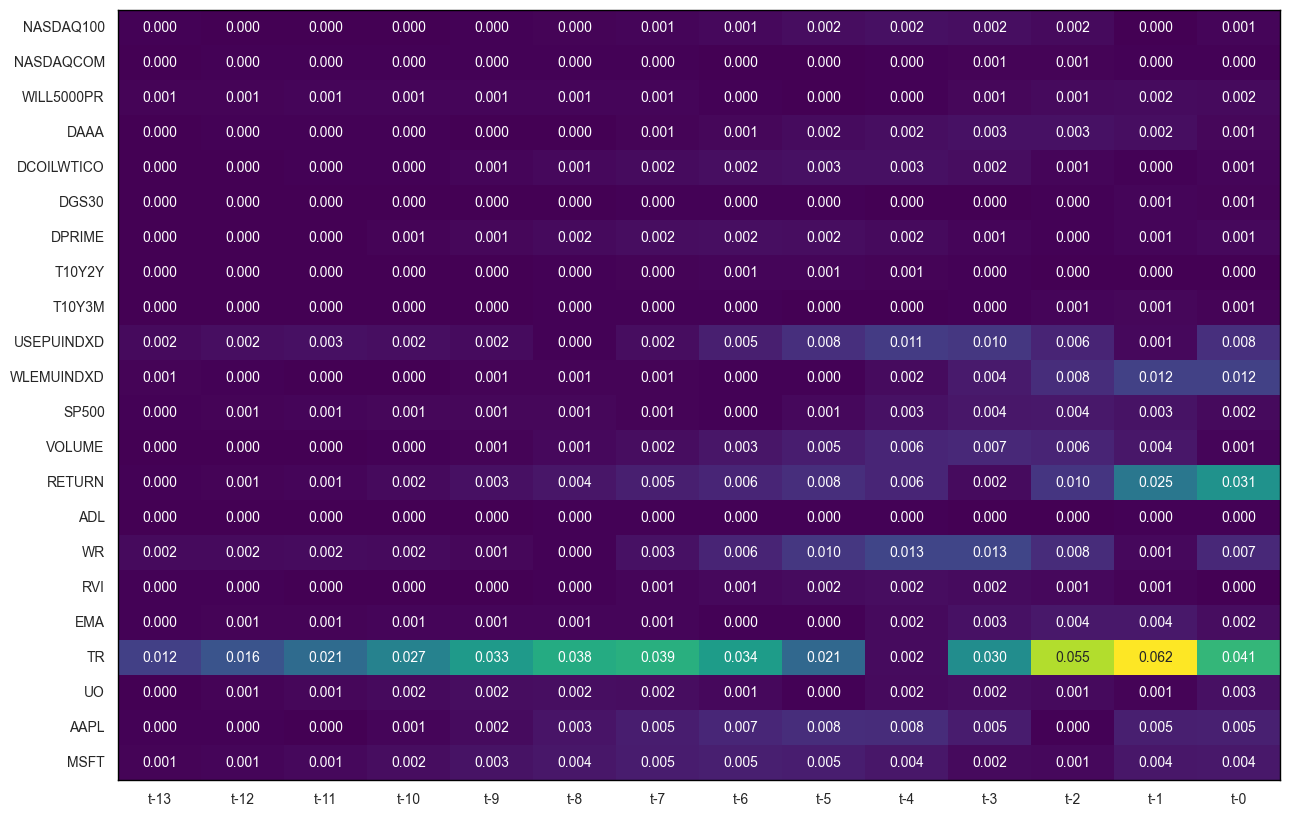

In [27]:
average_attributions_median_tensor = torch.from_numpy(average_attributions_median)

abs_attributions = torch.abs(average_attributions_median_tensor)

normalized_attributions = abs_attributions / torch.sum(abs_attributions)

normalized_attributions_np = normalized_attributions.cpu().numpy()

feature_names = ['NASDAQ100', 'NASDAQCOM', 'WILL5000PR', 'DAAA', 'DCOILWTICO',
                 'DGS30', 'DPRIME', 'T10Y2Y', 'T10Y3M', 'USEPUINDXD', 'WLEMUINDXD',
                 'SP500', 'VOLUME', 'RETURN', 'ADL', 'WR', 'RVI', 'EMA', 'TR', 'UO',
                 'AAPL', 'MSFT']

fig, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(normalized_attributions_np.T, cmap='viridis', ax=ax, annot=True, fmt=".3f", annot_kws={"size": 10}, cbar=False)

ax.set_yticklabels(feature_names, fontsize=10, rotation=0)  
ax.set_xticklabels([f't-{average_attributions_median_tensor.shape[0] - i - 1}' for i in range(average_attributions_median_tensor.shape[0])], rotation=0, fontsize=10)

for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)

plt.savefig('heatmap.svg')
plt.show()